In [1]:
# adjust plot size rendered inline
options(repr.plot.width = 6.5, repr.plot.height = 6.5, repr.plot.res = 300)

In [2]:
setwd("..")

In [4]:
library(dplyr)
library(readr)
library(tibble)
library(tidyr)
library(ggplot2)
library(ggpubr)
library(broom)
library(rjson)
library(RJSONIO)
library(purrr)
library(janitor)
library(cowplot)
library(rstatix)
library(vegan)

## Functions

In [5]:
ggplot_base <- theme_minimal() +
  theme(plot.title = element_text(size = 8),
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 7),
        legend.title = element_text(size = 6), 
        legend.text = element_text(size = 6),
        plot.title.position = "plot")

In [6]:
read_and_format_orpheum_json <- function(sys_glob_path, database, alphabet, ksize) {
  file_prefix = paste0("outputs\\/orpheum\\/", database, "\\/", alphabet, "-k", ksize, "\\/")
  json_df <- Sys.glob(sys_glob_path) %>%
    set_names() %>%
    map_dfr(~RJSONIO::fromJSON(content =., nullValue = NaN)$categorization_counts, .id = "sample") %>%
    clean_names() %>%
    mutate(sample = gsub(file_prefix, "", sample)) %>%
    mutate(sample = gsub(".summary\\.json", "", sample)) %>%
    mutate(database = database) %>%
    mutate(ksize = paste0("k=", ksize)) %>%
    mutate(alphabet = alphabet) %>%
    mutate(total_reads = rowSums(across(where(is.numeric))))
     
  return(json_df)
}

In [7]:
read_and_format_orpheum_json_translation <- function(sys_glob_path, database, alphabet, ksize) {
  file_prefix = paste0("outputs\\/orpheum\\/", database, "\\/", alphabet, "-k", ksize, "\\/")
  json_df <- Sys.glob(sys_glob_path) %>%
    set_names() %>%
    map_dfr(~RJSONIO::fromJSON(content =., nullValue = NaN)$histogram_n_coding_frames_per_read, .id = "sample") %>%
    clean_names() %>%
    mutate(sample = gsub(file_prefix, "", sample)) %>%
    mutate(sample = gsub("\\.summary\\.json", "", sample)) %>%
    mutate(database = database) %>%
    mutate(ksize = paste0("k=", ksize)) %>%
    mutate(alphabet = alphabet)
  
  # make sure numbers are encoded as numeric, then replace NAs with 0s and sum to coding
  json_df <- json_df %>%
    mutate(across(where(~ anyNA(.) & is.numeric(.)), ~ replace_na(., 0))) %>%
    mutate(coding_reads = rowSums(across(where(is.numeric))))
  
  # add missing cols
  columns <- c(number_of_reads_with_1_putative_protein_coding_translations = 0,
               number_of_reads_with_2_putative_protein_coding_translations = 0,
               number_of_reads_with_3_putative_protein_coding_translations = 0,
               number_of_reads_with_4_putative_protein_coding_translations = 0,
               number_of_reads_with_5_putative_protein_coding_translations = 0,
               number_of_reads_with_6_putative_protein_coding_translations = 0)
  json_df <- json_df %>%
    add_column(!!!columns[!names(columns) %in% names(.)])
  
  # calculate percentage of reads translated into n number of coding frames
  json_df <- json_df %>%
    mutate(f_putative_coding_1_translation = ifelse(number_of_reads_with_1_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_1_putative_protein_coding_translations/coding_reads)) %>%
    mutate(f_putative_coding_2_translation = ifelse(number_of_reads_with_2_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_2_putative_protein_coding_translations/coding_reads)) %>%
    mutate(f_putative_coding_3_translation = ifelse(number_of_reads_with_3_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_3_putative_protein_coding_translations/coding_reads)) %>%
    mutate(f_putative_coding_4_translation = ifelse(number_of_reads_with_4_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_4_putative_protein_coding_translations/coding_reads)) %>%
    mutate(f_putative_coding_5_translation = ifelse(number_of_reads_with_5_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_5_putative_protein_coding_translations/coding_reads)) %>%
    mutate(f_putative_coding_6_translation = ifelse(number_of_reads_with_6_putative_protein_coding_translations == 0, 0,
                                                    number_of_reads_with_6_putative_protein_coding_translations/coding_reads))
  
  return(json_df)
}

In [8]:
plot_orpheum_translation_frames <- function(orpheum_trans, ksize, alphabet, database){
  orpheum_trans_long <- orpheum_trans %>%
    select(sample, database, ksize, alphabet, starts_with("f_putative")) %>%
    pivot_longer(cols = starts_with("f_putative"), names_to = "translation_frame", values_to = "fraction") %>%
    mutate(translation_frame = gsub("f_putative_coding_", "", translation_frame)) %>%
    mutate(translation_frame = gsub("_translation", "", translation_frame))
  
  ggplot(orpheum_trans_long, aes(x = translation_frame, y = fraction)) +
    geom_violin(scale = "width") +
    theme_minimal() +
    ggplot_base +
    # geom_segment(aes(x = .5, y = .91, xend = 1.5, yend = .91), linetype = "dashed") +
    # geom_segment(aes(x = .5, y = .99, xend = 1.5, yend = .99), linetype = "dashed") +
    # geom_segment(aes(x = 1.5, y = .09, xend = 2.5, yend = .09), linetype = "dashed") +
    # geom_segment(aes(x = 1.5, y = .01, xend = 2.5, yend = .01), linetype = "dashed") +
    labs(x = "number of coding frames per read", y = "fraction of putative coding reads",
         title = paste0("db = ", database, ", alphabet = ", alphabet, ", k = ", ksize))
}

## Read in metadata

In [9]:
info <- read_tsv("inputs/all_genomes_genbank_info_metadata.tsv", show_col_types = F) %>%
  mutate(accession_minus_prefix = gsub("[12]$", "", accession_minus_prefix)) %>%
  mutate(set = gsub("refseq_not_in_genbank", "refseq_not_in_gtdb", set))

In [10]:
refseq <- read_tsv("inputs/refseq_not_in_gtdb_metadata.tsv", show_col_types = F)
gtdb <- read_tsv("inputs/gtdb_metadata.tsv", show_col_types = F)

In [11]:
gtdbtk <- read_tsv("outputs/gtdbtk/gtdbtk.ar122.summary.tsv", col_types = "cccdcddcddddccccdc", na = "N/A")
gtdbtk <- read_tsv("outputs/gtdbtk/gtdbtk.bac120.summary.tsv", col_types = "cccdcddcddddccccdc", na = "N/A") %>%
  bind_rows(gtdbtk) %>%
  mutate(user_genome = gsub("_genomic", "", user_genome)) %>%
  mutate(accession_minus_prefix = gsub("GCA_", "", user_genome)) %>%
  mutate(accession_minus_prefix = gsub("\\.[1-9].*", "", accession_minus_prefix)) %>%
  separate(classification, into=c("superkingdom", "phylum", "order", "class", "family", "genus", "species"), sep = ";")

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”


In [12]:
json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/gtdb-rs202/protein-k10/*json",
                                     database = "gtdb-rs202", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

## Read in orpheum results

In [13]:
translate <- read_and_format_orpheum_json_translation(sys_glob_path = "outputs/orpheum/gtdb-rs202/protein-k10/*json",
                                     database = "gtdb-rs202", 
                                     alphabet = "protein",
                                     ksize = 10) %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [14]:
json_long <- json %>%
  select(accession_minus_prefix, type, set, total_reads,
         translation_is_shorter_than_peptide_k_mer_size_1, 
         translation_frame_has_stop_codon_s, coding, non_coding, low_complexity_nucleotide,
         read_length_was_shorter_than_3_peptide_k_mer_size, low_complexity_peptide_in_protein20_alphabet) %>%
  pivot_longer(cols = translation_is_shorter_than_peptide_k_mer_size_1:low_complexity_peptide_in_protein20_alphabet, names_to = "measurement", values_to = "reads")

In [15]:
json_long_pct <- json_long %>%
  mutate(pct = reads/total_reads * 100) 

In [16]:
head(json_long_pct)

accession_minus_prefix,type,set,total_reads,measurement,reads,pct
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
000008025,cds,gtdb_representatives,127000,translation_is_shorter_than_peptide_k_mer_size_1,0,0.000000
000008025,cds,gtdb_representatives,127000,translation_frame_has_stop_codon_s,10164,8.003150
000008025,cds,gtdb_representatives,127000,coding,111478,87.777953
000008025,cds,gtdb_representatives,127000,non_coding,5358,4.218898
000008025,cds,gtdb_representatives,127000,low_complexity_nucleotide,0,0.000000
000008025,cds,gtdb_representatives,127000,read_length_was_shorter_than_3_peptide_k_mer_size,0,0.000000


In [17]:
# ggplot(json_long, aes(x = reorder(accession_minus_prefix, total_reads), y = reads, fill = measurement)) +
#   geom_col() +
#   theme_minimal() +
#   theme(legend.position = "bottom") +
#   coord_flip() +
#   facet_wrap(~ type + set, scales = "free_y") +
#   scale_fill_brewer(palette = "Dark2") +
#   guides(fill = guide_legend(nrow = 4))

In [18]:
# ggplot(json_long %>% filter(measurement %in% c("coding", "non_coding")), 
#        aes(x = reorder(accession_minus_prefix, total_reads), y = reads, fill = measurement)) +
#   geom_col() +
#   theme_minimal() +
#   coord_flip() +
#   facet_wrap(~ type + set, scales = "free_y") +
#   scale_fill_brewer(palette = "Dark2")

In [19]:
# plot_order_cds <- json_long_pct %>%
#   select(accession_minus_prefix, type, measurement, pct) %>%
#   filter(measurement == "coding") %>%
#   filter(type == "cds") %>%
#   arrange(desc(pct)) %>%
#   mutate(plot_order = 1:42) %>%
#   select(accession_minus_prefix, plot_order)
# 
# json_long_pct <- json_long_pct %>%
#   left_join(plot_order_cds)
# 
# ggplot(json_long_pct, 
#        aes(x = reorder(accession_minus_prefix, plot_order), y = pct, label = round(pct, digits = 0), fill = measurement)) +
#   geom_col() +
#   theme_minimal() +
#   theme(legend.position = "bottom") +
#   geom_text(size = 3, position = position_stack(vjust = 0.5)) + 
#   coord_flip() +
#   facet_wrap(~ type + set, scales = "free_y") +
#   scale_fill_brewer(palette = "Dark2") +
#   guides(fill = guide_legend(nrow = 4))

### plot orpheum results

In [20]:
plot_order_cds <- json_long_pct %>%
  select(accession_minus_prefix, type, measurement, pct) %>%
  filter(measurement == "coding") %>%
  filter(type == "cds") %>%
  arrange(desc(pct)) %>%
  mutate(plot_order = 1:42) %>%
  select(accession_minus_prefix, plot_order)

json_long_pct <- json_long_pct %>%
  left_join(plot_order_cds) %>%
  left_join(gtdbtk)

# fix species labels for "s__" and "g__"
json_long_pct <- json_long_pct %>%
  mutate(species = ifelse(species == "s__", genus, species)) %>%
  mutate(species = ifelse(species == "g__", family, species))

# change category to "other" for measurements
json_long_pct <- json_long_pct %>%
  mutate(measurement2 = ifelse(measurement %in% c("coding", "non_coding"), measurement, "other")) %>%
  group_by(accession_minus_prefix, type, set, species, plot_order, measurement2) %>%
  summarize(pct2 = sum(pct))

Joining, by = "accession_minus_prefix"
Joining, by = "accession_minus_prefix"
`summarise()` has grouped output by 'accession_minus_prefix', 'type', 'set', 'species', 'plot_order'. You can override using the `.groups` argument.


In [21]:
# plot Genome in GTDB set
cds_noncds_gtdb_plt <- ggplot(json_long_pct %>% 
         mutate(species = gsub(".__", "", species)) %>% 
         filter(set == "gtdb_representatives"), 
       aes(x = reorder(species, plot_order), y = pct2, label = round(pct2, digits = 0), fill = measurement2)) +
  geom_col() +
  theme_minimal() +
  theme(legend.position = "right",
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.text.y = element_text(face = "italic", size = 6),
        axis.title.y = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        strip.text = element_text(face = "bold")) +
  geom_text(size = 2, position = position_stack(vjust = 0.5)) + 
  coord_flip() +
  labs(x = "species", y = "percent of reads", fill = "read type") +
  facet_grid(~ set ~ type, scales = "free", space = "free", 
             labeller = as_labeller(c(cds = "Coding", noncds = "Non-coding", 
                                      gtdb_representatives = "Genome in GTDB",
                                      refseq_not_in_gtdb = "Genome not in GTDB"))) +
  scale_fill_brewer(palette = "Dark2", labels = c("Coding", "Non-coding", "Other")) +
  guides(fill = guide_legend(nrow = 4))

In [22]:
# plot Genome not in GTDB set
cds_noncds_nongtdb_plt <- ggplot(json_long_pct %>% 
         mutate(species = gsub(".__", "", species)) %>% 
         filter(set == "refseq_not_in_gtdb"), 
       aes(x = reorder(species, plot_order), y = pct2, label = round(pct2, digits = 0), fill = measurement2)) +
  geom_col() +
  theme_minimal() +
  theme(legend.position = "right",
        axis.text = element_text(size = 6),
        axis.text.y = element_text(face = "italic"),
        axis.title = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6),
        strip.text.x = element_blank(),
        strip.text.y = element_text(face = "bold")) +
  geom_text(size = 2, position = position_stack(vjust = 0.5)) + 
  coord_flip() +
  labs(x = "species", y = "percent of reads", fill = "read type") +
  facet_grid(~ set ~ type, scales = "free", space = "free", 
             labeller = as_labeller(c(cds = "Coding", noncds = "Non-coding", 
                                      gtdb_representatives = "Genome in GTDB",
                                      refseq_not_in_gtdb = "Genome not in GTDB"))) +
  scale_fill_brewer(palette = "Dark2", labels = c("Coding", "Non-coding", "Other")) +
  guides(fill = guide_legend(nrow = 4))


In [23]:
# combine plots
legend <- get_legend(cds_noncds_gtdb_plt) # extract the legend from one of the plots
tmp <- plot_grid(cds_noncds_gtdb_plt + theme(legend.position="none"), 
                 cds_noncds_nongtdb_plt+ theme(legend.position="none"), 
                 ncol=1, align='v', rel_heights = c(1.2, 1))
cds_noncds_gtdb_nongtdb_plt <- plot_grid(tmp, legend, rel_widths = c(6, 1))

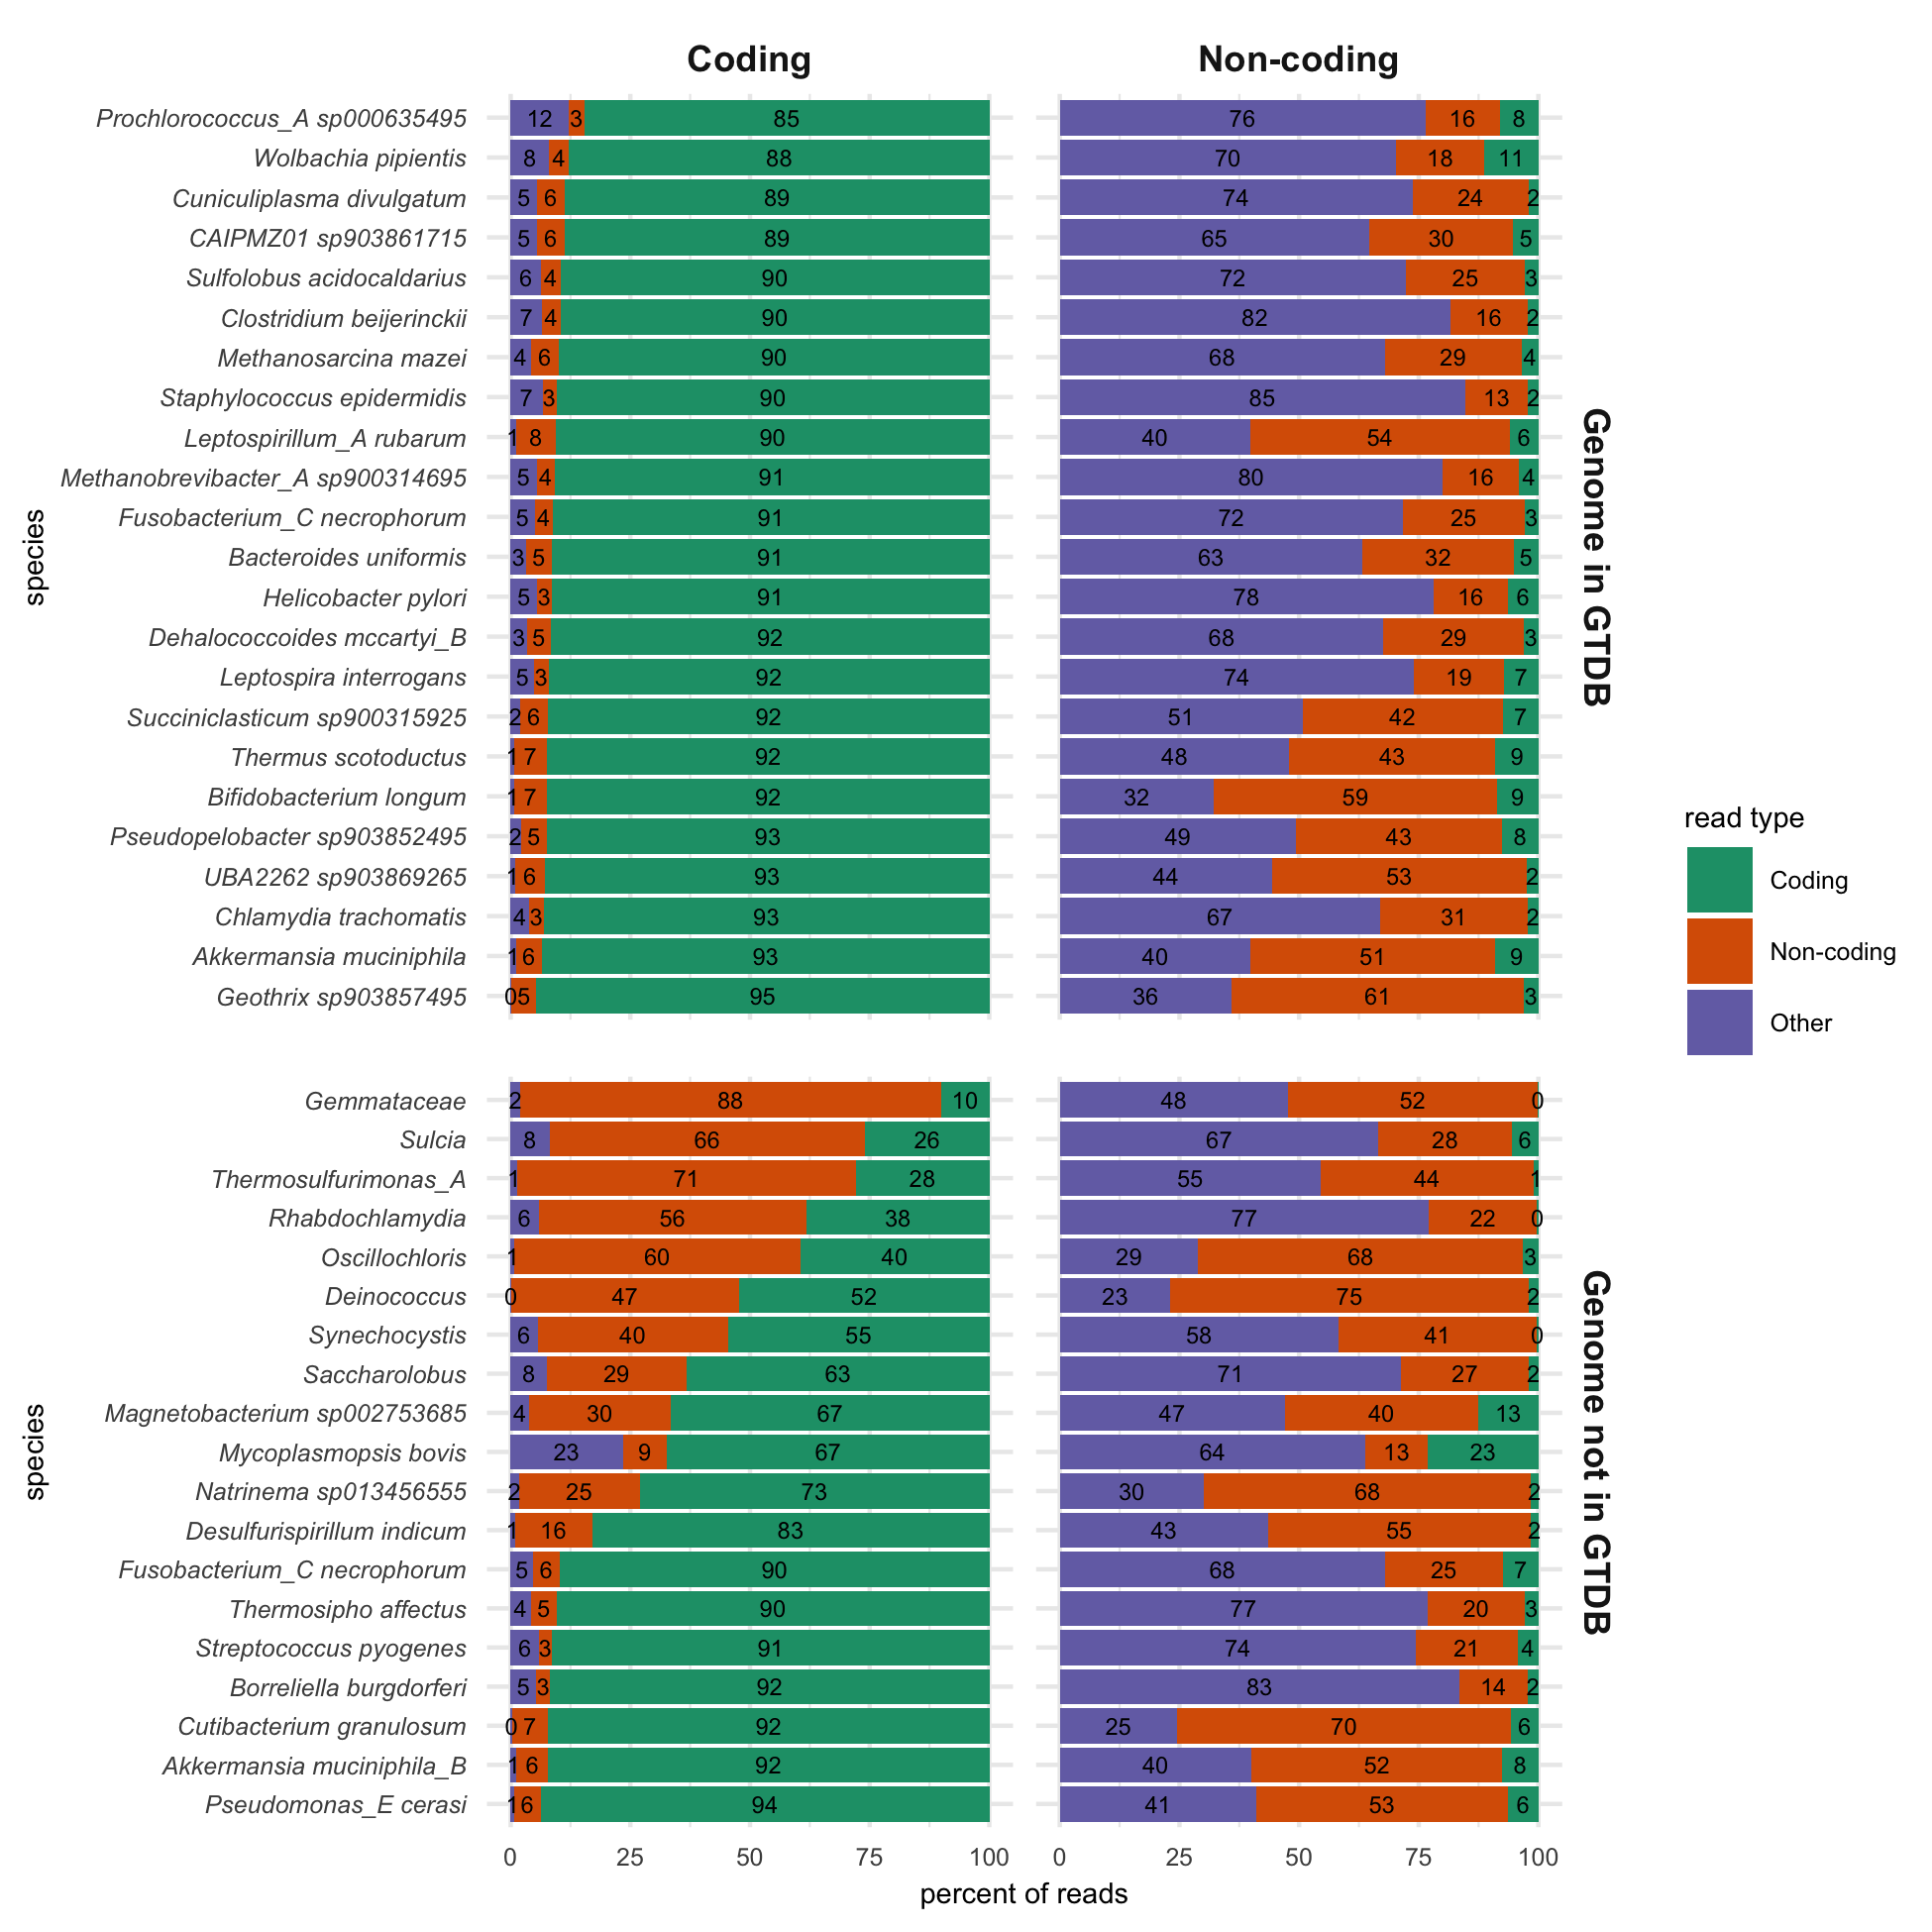

In [24]:
cds_noncds_gtdb_nongtdb_plt

In [25]:
json_long_pct %>% 
  group_by(set, type, measurement2) %>%
  summarize(mean = mean(pct2),
            sd = sd(pct2))

`summarise()` has grouped output by 'set', 'type'. You can override using the `.groups` argument.


set,type,measurement2,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
gtdb_representatives,cds,coding,90.958545,2.173304
gtdb_representatives,cds,non_coding,4.925914,1.491746
gtdb_representatives,cds,other,4.115540,2.890204
gtdb_representatives,noncds,coding,5.285284,2.796175
gtdb_representatives,noncds,non_coding,32.404438,15.325774
gtdb_representatives,noncds,other,62.310278,16.064694
refseq_not_in_gtdb,cds,coding,65.442768,26.783387
refseq_not_in_gtdb,cds,non_coding,30.160576,27.122039
refseq_not_in_gtdb,cds,other,4.396655,5.257614


## RefSeq not in GTDB

Orpheum performs increasingly poorly with increasingly large relatedness between the query genome and the closest related genome in GTDB.
If there is a species-level representative in the database, orpheum performs pretty well. 

In [26]:
json_long_pct_refseq <- json_long_pct %>%
  filter(set == "refseq_not_in_gtdb") %>%
  filter(measurement2 == "coding") %>%
  filter(type == "cds") 

In [27]:
json_long_pct_refseq  <- json_long_pct_refseq  %>%
  mutate(classification_level = ifelse(grepl("f__", species), "family",
                                       ifelse(grepl("g__", species), "genus", "species")))

In [28]:
refseq_gtdbtk_plt <- ggplot(json_long_pct_refseq , aes(x = classification_level, y = pct2, 
                                                       label = accession_minus_prefix,
                                                       color = classification_level)) +
  geom_boxplot() +
  geom_point() +
  theme_minimal() +
  ylim(c(0, 100)) +
  theme(legend.position = "none",
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6)) +
  labs(x = "Classification level by GTDB-Tk", y = "percent CDS reads\npredicted as coding") +
  scale_color_manual(values = c("family" = "#33A02C", genus = "#B2DF8A", species = "#1F78B4"))

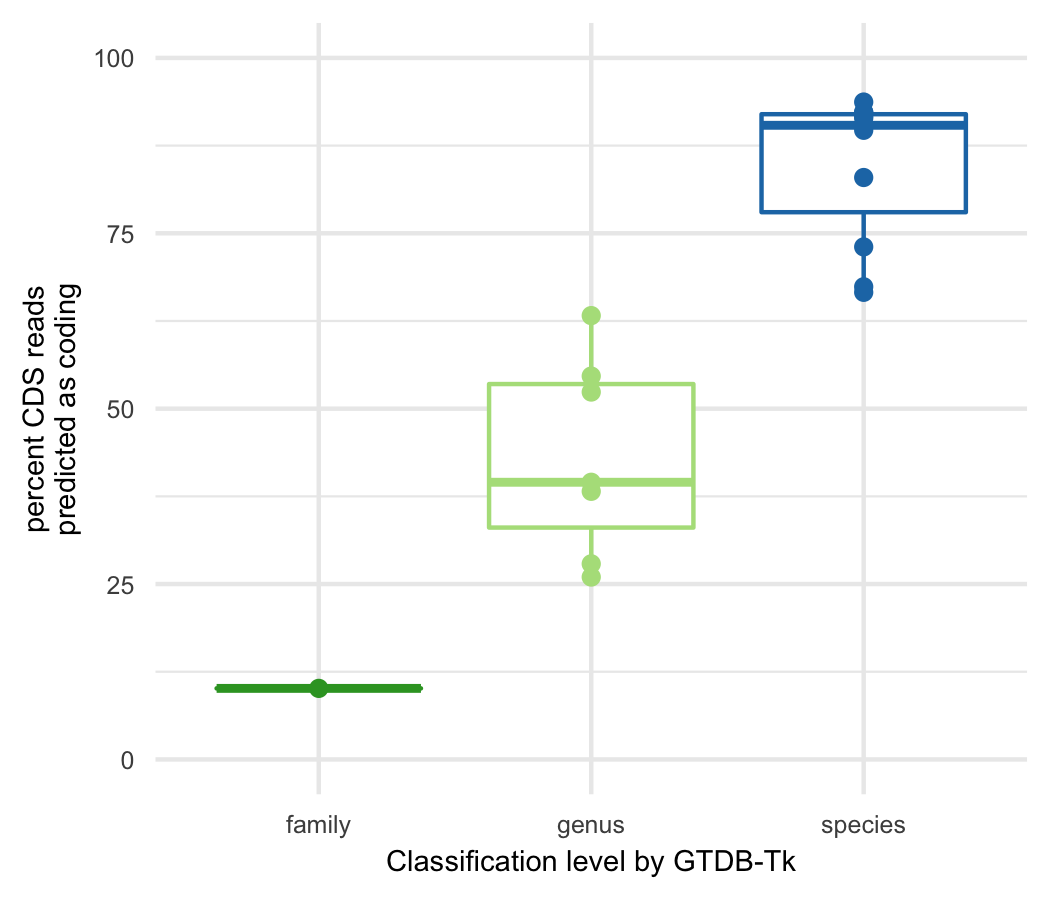

In [33]:
# adjust plot size rendered inline
options(repr.plot.width = 3.5, repr.plot.height = 3, repr.plot.res = 300)

refseq_gtdbtk_plt

## Jaccard Similarity cutoff

In [34]:
cutoffs <- Sys.glob("outputs/orpheum_cutoffs/gtdb-rs202/protein-k10/*tsv") %>%
  map_dfr(read_tsv, show_col_types = F) 

In [35]:
cutoffs <- cutoffs %>%
  left_join(info, by = c("accession" = "assembly_accession")) %>%
  left_join(gtdbtk, by = c("accession" = "user_genome")) %>%
  mutate(closest_classification_level = 
           ifelse(genus == "g__", "family",
                  ifelse(species == "s__", "genus", "species"))) %>%
  mutate(closest_classification_level = ifelse(set == "gtdb_representatives", 
                                               "genome", 
                                               closest_classification_level))

In [36]:
cutoffs$closest_classification_level <- factor(cutoffs$closest_classification_level,
                                               levels = c("genome", 
                                                          "species",
                                                          "genus", 
                                                          "family"))

In [37]:
tmp <- cutoffs %>%
  group_by(jaccard_cutoff, closest_classification_level) %>%
  summarize(mean_sensitivity = mean(sensitivity),
            mean_specificity = mean(specificity), 
            mean_youden = mean(youden_index))

`summarise()` has grouped output by 'jaccard_cutoff'. You can override using the `.groups` argument.


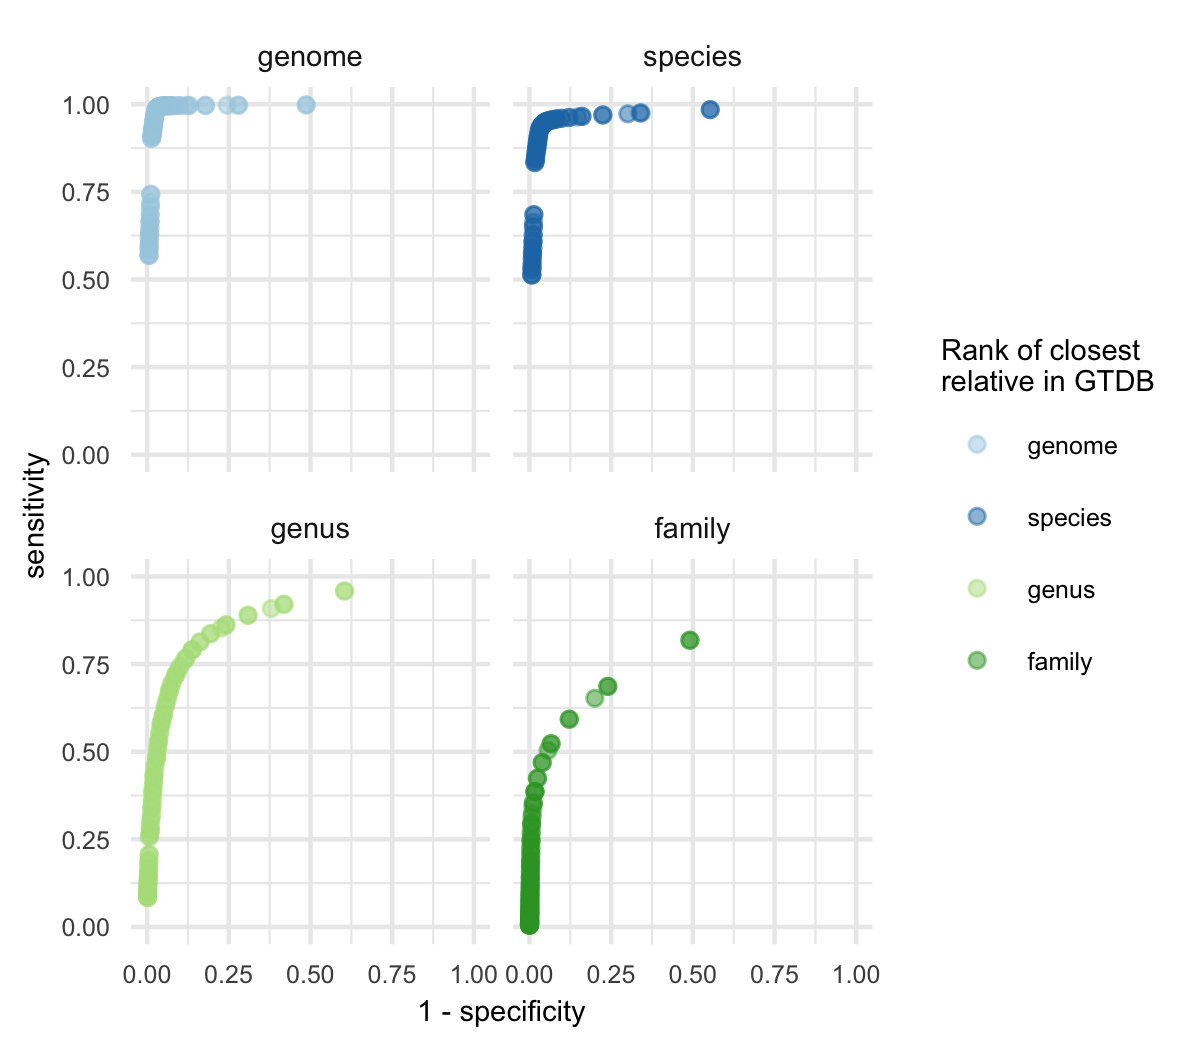

In [40]:
# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 300)

jaccard_tp_plt  <- ggplot(tmp, aes(x = 1-mean_specificity, y = mean_sensitivity, color = closest_classification_level)) +
  geom_point(alpha = .5) +
  xlim(0, 1) + ylim(0, 1) +
  facet_wrap(~closest_classification_level) + 
  labs(x = "1 - specificity", y = "sensitivity",
       color = "Rank of closest\nrelative in GTDB") +
  theme_minimal() +
  theme(legend.position = "right",
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 7),
        strip.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.text = element_text(size = 6)) +
  scale_color_brewer(palette = "Paired") +
  guides(fill = guide_legend(nrow = 5))

jaccard_tp_plt

In [41]:
tmp %>%
  group_by(closest_classification_level) %>%
  arrange(desc(mean_youden)) %>%
  slice(1)

jaccard_cutoff,closest_classification_level,mean_sensitivity,mean_specificity,mean_youden
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
0.47,genome,0.9877607,0.9707856,0.9585462
0.39,species,0.9407738,0.9614734,0.9022473
0.17,genus,0.7903187,0.8624493,0.6527680
0.07,family,0.5928131,0.8783289,0.4711420


## Lineage plots

For two species, see what databases account for the majority of orpheums ability to predict the open reading frame accurately.

Each database was built to include all members of the same taxonomy at that rank in the lineage. 

In both cases, the species-level database led to the most predicative capability.

### C beij

In [69]:
cbeij_gtdb <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/gtdb-rs202/protein-k10/GCA_002006445.1*json",
                                     database = "gtdb-rs202", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [70]:
cbeij_phylum <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/p__Firmicutes_A/protein-k10/GCA_002006445.1*json",
                                     database = "p__Firmicutes_A", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [71]:
cbeij_class <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/c__Clostridia/protein-k10/GCA_002006445.1*json",
                                     database = "c__Clostridia", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [72]:
cbeij_order <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/o__Clostridiales/protein-k10/GCA_002006445.1*json",
                                     database = "o__Clostridiales", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [73]:
cbeij_family <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/f__Clostridiaceae/protein-k10/GCA_002006445.1*json",
                                     database = "f__Clostridiaceae", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [74]:
cbeij_genus <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/g__Clostridium/protein-k10/GCA_002006445.1*json",
                                     database = "g__Clostridium", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [75]:
cbeij_species <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/s__Clostridium_beijerincki/protein-k10/GCA_002006445.1*json",
                                     database = "s__Clostridium_beijerincki", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

In [76]:
cbeij <- bind_rows(cbeij_species, cbeij_genus, cbeij_family, cbeij_order,
                   cbeij_class, cbeij_phylum, cbeij_gtdb)

In [77]:
cbeij_long_pct <- cbeij %>%
  select(accession_minus_prefix, type, set, database, total_reads,
         translation_is_shorter_than_peptide_k_mer_size_1, 
         translation_frame_has_stop_codon_s, coding, non_coding, low_complexity_nucleotide,
         read_length_was_shorter_than_3_peptide_k_mer_size, low_complexity_peptide_in_protein20_alphabet) %>%
  pivot_longer(cols = translation_is_shorter_than_peptide_k_mer_size_1:low_complexity_peptide_in_protein20_alphabet, names_to = "measurement", values_to = "reads") %>%
  mutate(pct = reads/total_reads * 100) 

In [78]:
cbeij_long_pct <- cbeij_long_pct %>%
   left_join(gtdbtk)

Joining, by = "accession_minus_prefix"


In [79]:
# change category to "other" for measurements
cbeij_long_pct <- cbeij_long_pct %>%
  mutate(measurement2 = ifelse(measurement %in% c("coding", "non_coding"), measurement, "other")) %>%
  group_by(accession_minus_prefix, type, set, species, measurement2, database) %>%
  summarize(pct2 = sum(pct))

`summarise()` has grouped output by 'accession_minus_prefix', 'type', 'set', 'species', 'measurement2'. You can override using the `.groups` argument.


In [80]:
cbeij_long_pct$database <- factor(cbeij_long_pct$database, levels = c('gtdb-rs202', 'p__Firmicutes_A', 'c__Clostridia', 'o__Clostridiales', 'f__Clostridiaceae', 'g__Clostridium', 's__Clostridium_beijerincki'))

In [81]:
lineage_plt <- ggplot(cbeij_long_pct, 
                      aes(x = database, y = pct2, label = round(pct2, digits = 2), fill = measurement2)) +
  geom_col() +
  theme_minimal() +
  theme(legend.position = "bottom",
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7),
        strip.text = element_text(size = 8),
        panel.spacing = unit(.1, "lines")) +
  geom_text(size = 2, position = position_stack(vjust = 0.5)) + 
  coord_flip() +
  labs(x = "species", y = "percent of reads", fill = "read type") +
  facet_wrap(~ type + set, scales = "free_y", 
             labeller = as_labeller(c(cds = "Coding", noncds = "Non-coding", 
                                      gtdb_representatives = "Genome in GTDB",
                                      refseq_not_in_gtdb = "Genome not in GTDB"))) +
  scale_fill_brewer(palette = "Dark2", labels = c("Coding", "Non-coding", "Other")) +
  guides(fill = guide_legend(nrow = 1))

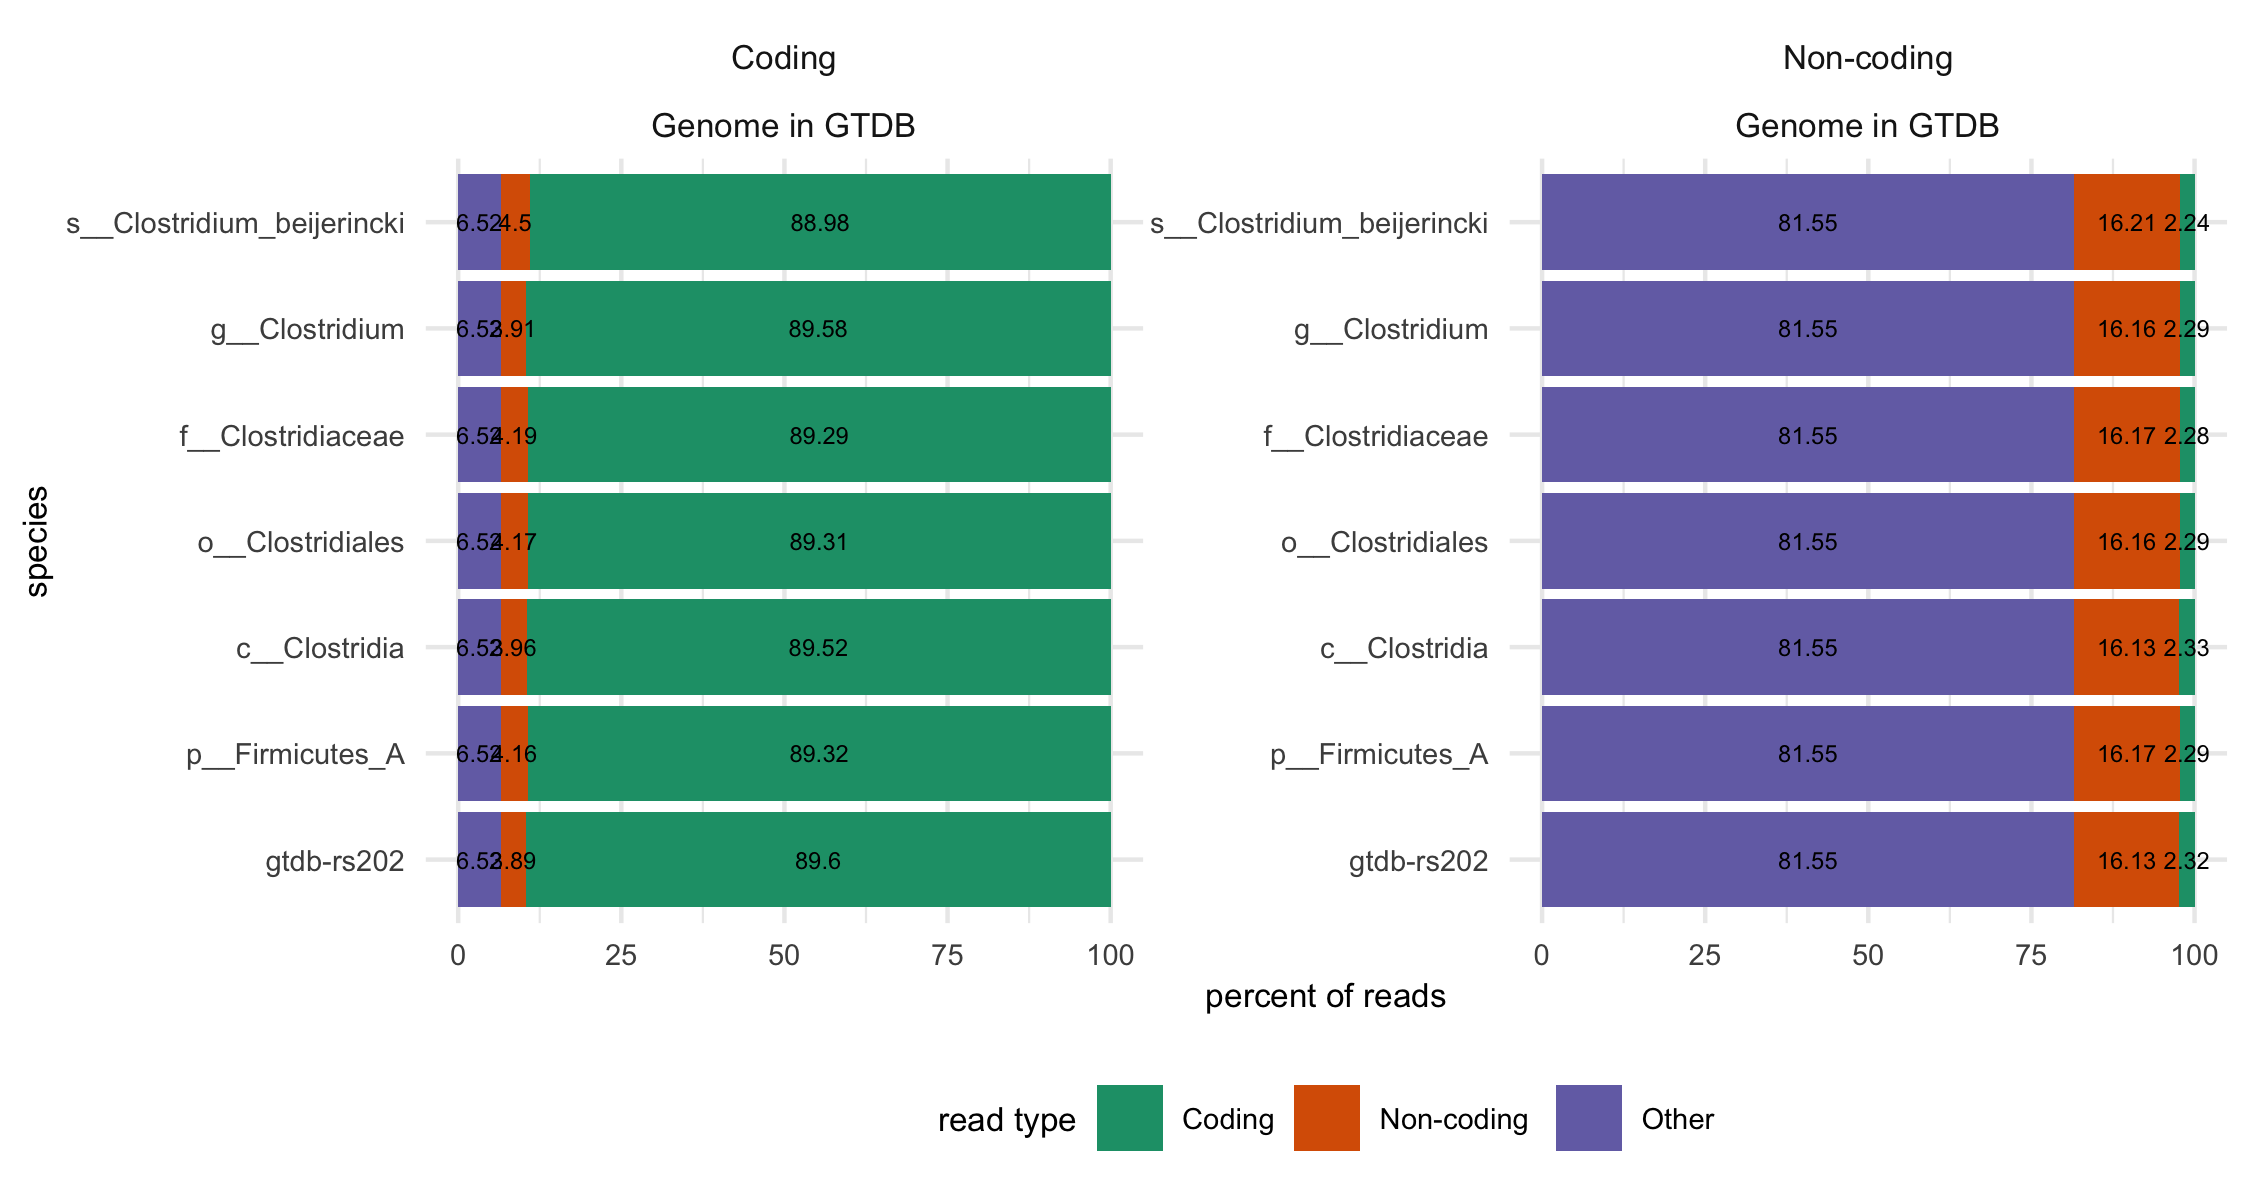

In [83]:
# adjust plot size rendered inline
options(repr.plot.width = 7.5, repr.plot.height = 4, repr.plot.res = 300)

lineage_plt

### Thermo

In [84]:
thermo_gtdb <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/gtdb-rs202/protein-k10/GCA_018588215.1*json",
                                     database = "gtdb-rs202", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_phylum <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/p__Thermotogota/protein-k10/GCA_018588215.1*json",
                                     database = "p__Thermotogota", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_class <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/c__Thermotogae/protein-k10/GCA_018588215.1*json",
                                     database = "c__Thermotogae", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_order <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/o__Thermotogales/protein-k10/GCA_018588215.1*json",
                                     database = "o__Thermotogales", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_family <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/f__Fervidobacteriaceae/protein-k10/GCA_018588215.1*json",
                                     database = "f__Fervidobacteriaceae", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_genus <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/g__Thermosipho/protein-k10/GCA_018588215.1*json",
                                     database = "g__Thermosipho", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo_species <- json <- read_and_format_orpheum_json(sys_glob_path = "outputs/orpheum/s__Thermosipho_affectus/protein-k10/GCA_018588215.1*json",
                                     database = "s__Thermosipho_affectus", 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
  separate(sample, into = c("prefix", "accession_minus_prefix", "type"), sep = "_", remove = F) %>%
  mutate(accession_minus_prefix = gsub("\\..*", "", accession_minus_prefix)) %>%
  left_join(info, by = "accession_minus_prefix")

thermo <- bind_rows(thermo_species, thermo_genus, thermo_family, thermo_order,
                    thermo_class, thermo_phylum, thermo_gtdb)

In [85]:
thermo_long_pct <- thermo %>%
  select(accession_minus_prefix, type, set, database, total_reads,
         translation_is_shorter_than_peptide_k_mer_size_1, 
         translation_frame_has_stop_codon_s, coding, non_coding, low_complexity_nucleotide,
         read_length_was_shorter_than_3_peptide_k_mer_size, low_complexity_peptide_in_protein20_alphabet) %>%
  pivot_longer(cols = translation_is_shorter_than_peptide_k_mer_size_1:low_complexity_peptide_in_protein20_alphabet, names_to = "measurement", values_to = "reads") %>%
  mutate(pct = reads/total_reads * 100) 

thermo_long_pct <- thermo_long_pct %>%
   left_join(gtdbtk)

Joining, by = "accession_minus_prefix"


In [86]:
# change category to "other" for measurements
thermo_long_pct <- thermo_long_pct %>%
  mutate(measurement2 = ifelse(measurement %in% c("coding", "non_coding"), measurement, "other")) %>%
  group_by(accession_minus_prefix, type, set, species, measurement2, database) %>%
  summarize(pct2 = sum(pct))

thermo_long_pct$database <- factor(thermo_long_pct$database, levels = c('gtdb-rs202', 'p__Thermotogota', 'c__Thermotogae', 'o__Thermotogales', 'f__Fervidobacteriaceae', 'g__Thermosipho', 's__Thermosipho_affectus'))

`summarise()` has grouped output by 'accession_minus_prefix', 'type', 'set', 'species', 'measurement2'. You can override using the `.groups` argument.


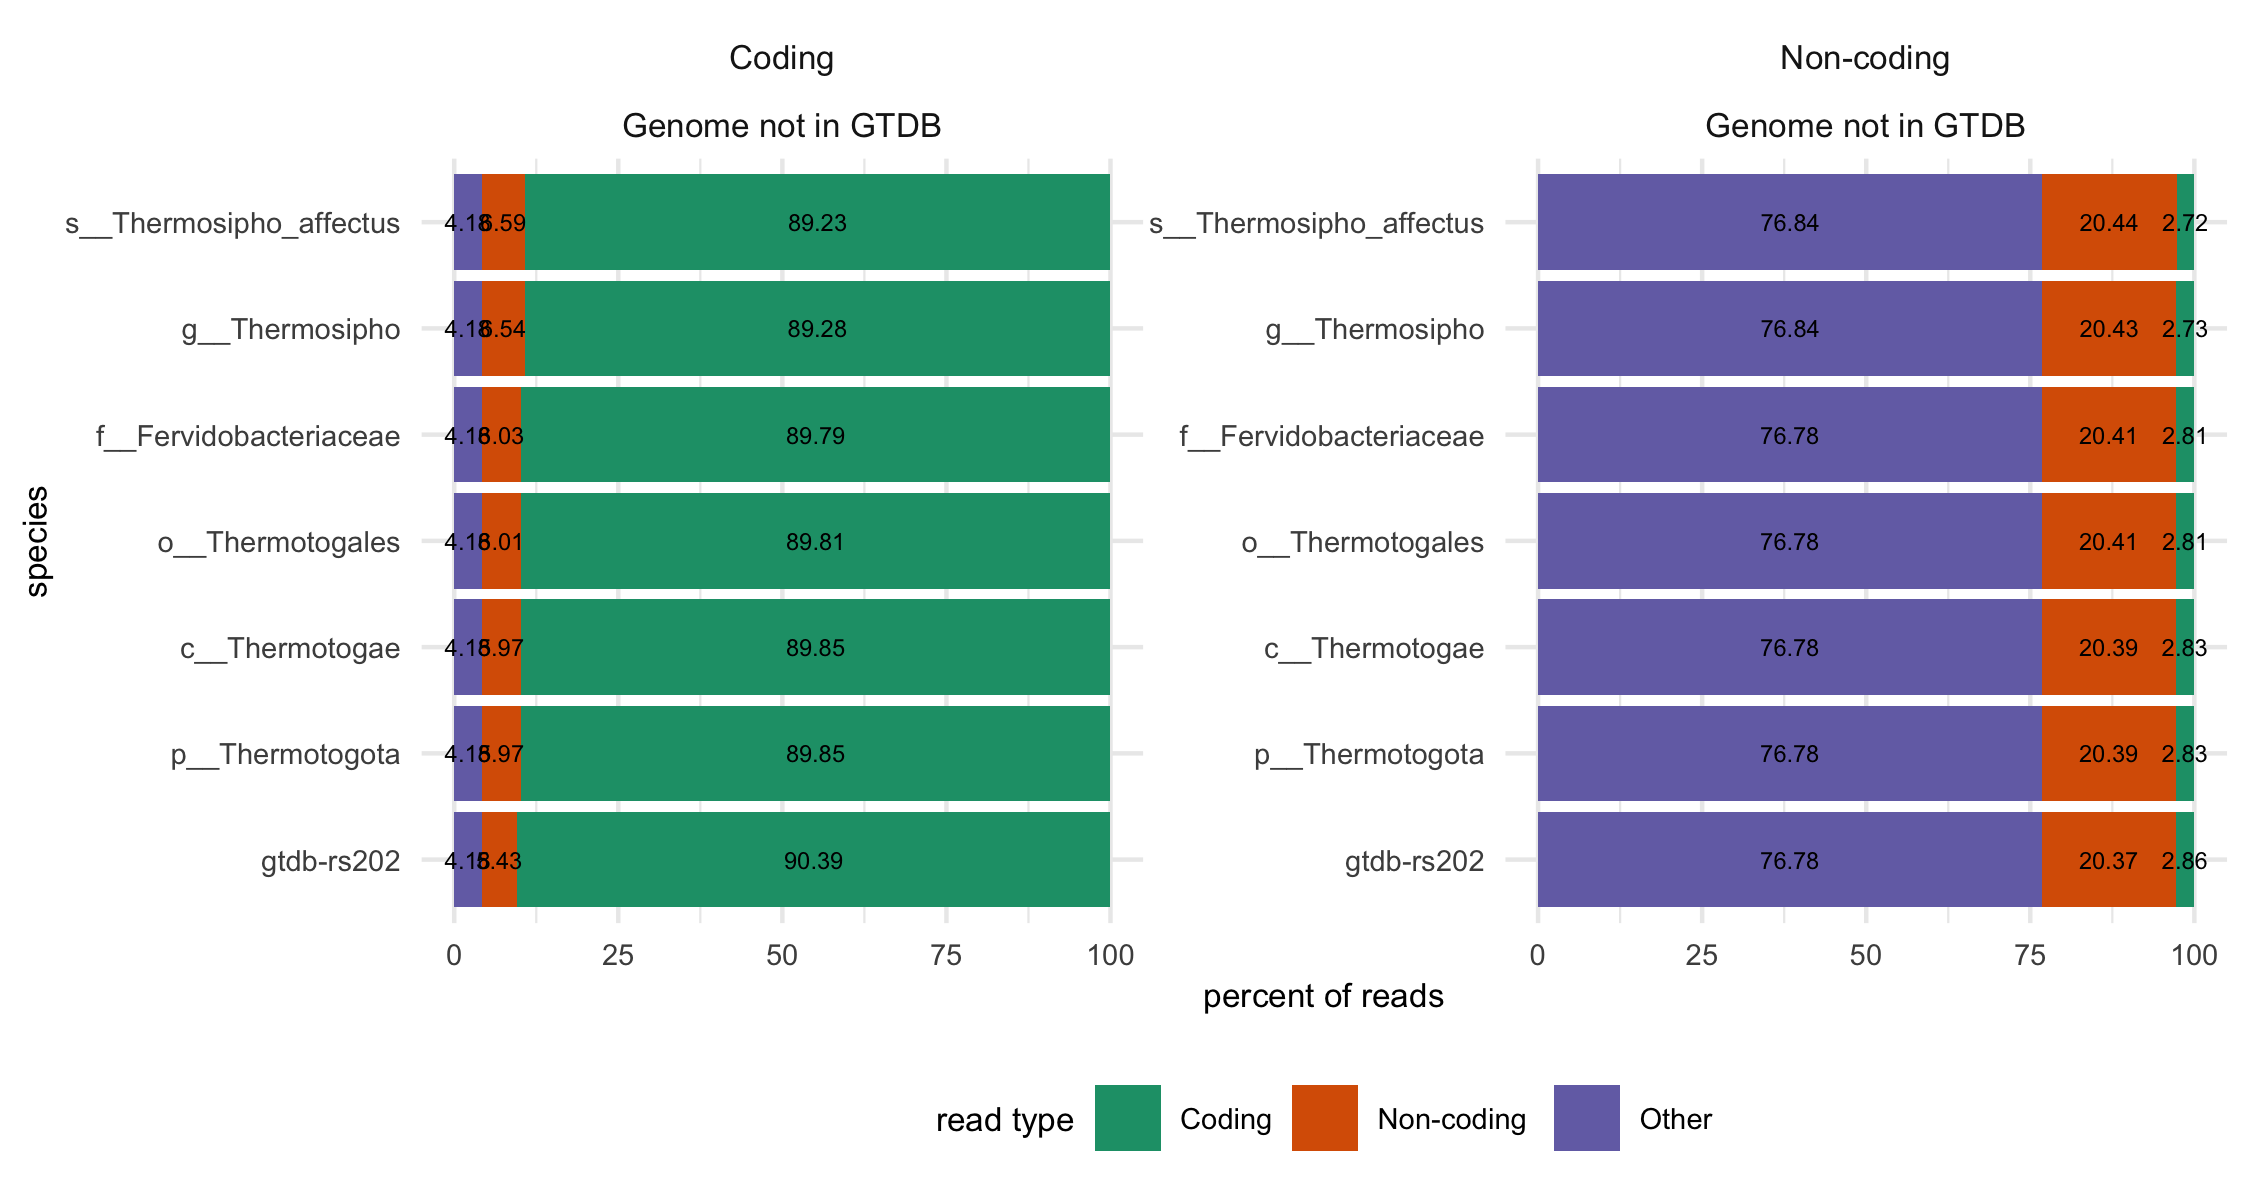

In [87]:
lineage_plt <- ggplot(thermo_long_pct, 
                      aes(x = database, y = pct2, label = round(pct2, digits = 2), fill = measurement2)) +
  geom_col() +
  theme_minimal() +
  theme(legend.position = "bottom",
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7),
        strip.text = element_text(size = 8),
        panel.spacing = unit(.1, "lines")) +
  geom_text(size = 2, position = position_stack(vjust = 0.5)) + 
  coord_flip() +
  labs(x = "species", y = "percent of reads", fill = "read type") +
  facet_wrap(~ type + set, scales = "free_y", 
             labeller = as_labeller(c(cds = "Coding", noncds = "Non-coding", 
                                      gtdb_representatives = "Genome in GTDB",
                                      refseq_not_in_gtdb = "Genome not in GTDB"))) +
  scale_fill_brewer(palette = "Dark2", labels = c("Coding", "Non-coding", "Other")) +
  guides(fill = guide_legend(nrow = 1))
lineage_plt

## Species vs. GTDB plots

In [88]:
species_json_files <- Sys.glob("outputs/orpheum_species/*json") 
species_jsons <- data.frame()

for(i in 1:length(species_json_files)){
  db <- species_json_files[i]
  db <- gsub("outputs\\/orpheum_species\\/GCA_[0-9]{9}\\.[12]{1}-cds-", "", db)
  db <- gsub("outputs\\/orpheum_species\\/GCA_[0-9]{9}\\.[12]{1}-noncds-", "", db)
  db <- gsub(".summary.json", "", db)

  species_json <- read_and_format_orpheum_json(sys_glob_path = species_json_files[i],
                                     database = db, 
                                     alphabet = "protein",
                                     ksize = 10)  %>%
    mutate(sample = gsub("outputs\\/orpheum_species\\/", "", sample)) %>%
    mutate(sample = gsub("-s__.*", "", sample)) %>%
    mutate(sample = gsub(".summary.json", "", sample)) %>%
    separate(sample, into = c("accession", "type"), sep = "-", remove = F) %>%
    mutate(accession_minus_version = gsub("\\..*", "", accession)) %>%
    mutate(accession_minus_prefix = gsub("GCA_", "", accession_minus_version)) %>%
    left_join(info, by = "accession_minus_prefix")
  
  species_jsons <- bind_rows(species_jsons, species_json)
}

In [89]:
species_jsons_pct <- species_jsons %>%
  select(accession_minus_prefix, type, set, database, total_reads,
         translation_is_shorter_than_peptide_k_mer_size_1, 
         translation_frame_has_stop_codon_s, coding, non_coding, low_complexity_nucleotide,
         read_length_was_shorter_than_3_peptide_k_mer_size, low_complexity_peptide_in_protein20_alphabet) %>%
  pivot_longer(cols = translation_is_shorter_than_peptide_k_mer_size_1:low_complexity_peptide_in_protein20_alphabet, names_to = "measurement", values_to = "reads") %>%
  mutate(pct = reads/total_reads * 100)

In [90]:
species_jsons_pct <- species_jsons_pct %>%
   left_join(gtdbtk)

Joining, by = "accession_minus_prefix"


In [91]:
# change category to "other" for measurements
species_jsons_pct <- species_jsons_pct %>%
  mutate(measurement2 = ifelse(measurement %in% c("coding", "non_coding"), measurement, "other")) %>%
  group_by(accession_minus_prefix, type, set, species, measurement2, database) %>%
  summarize(pct2 = sum(pct))

`summarise()` has grouped output by 'accession_minus_prefix', 'type', 'set', 'species', 'measurement2'. You can override using the `.groups` argument.


In [92]:
tmp <- species_jsons_pct %>%
  ungroup() %>%
  select(species, type,set, measurement2, species_pct = pct2)

tmp2 <- json_long_pct %>%
  ungroup() %>%
  select(species, type, set, measurement2, gtdb_pct = pct2)

tmp <- left_join(tmp, tmp2)

tmp_long <- tmp %>% 
  filter(type == "cds") %>% 
  filter(measurement2 == "coding") %>%
  select(species, species_pct, gtdb_pct) %>%
  pivot_longer(cols = -species) %>%
  mutate(name = gsub("species_pct", "species database", name),
         name = gsub("gtdb_pct", "GTDB rs202 database", name))

Joining, by = c("species", "type", "set", "measurement2")


In [93]:
bxp <- ggpaired(data = tmp_long, x = "name", y = "value", id = "species",
                line.color = "lightgrey", xlab = "database", ylab = "percent CDS reads\npredicted as coding")

stat_test <- tmp_long  %>% 
  t_test(value ~ name, paired = TRUE) %>%
  add_significance()
stat_test

stat_test <- stat_test %>% add_xy_position(x = "name")

.y.,group1,group2,n1,n2,statistic,df,p,p.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
value,GTDB rs202 database,species database,34,34,-1.337701,33,0.19,ns


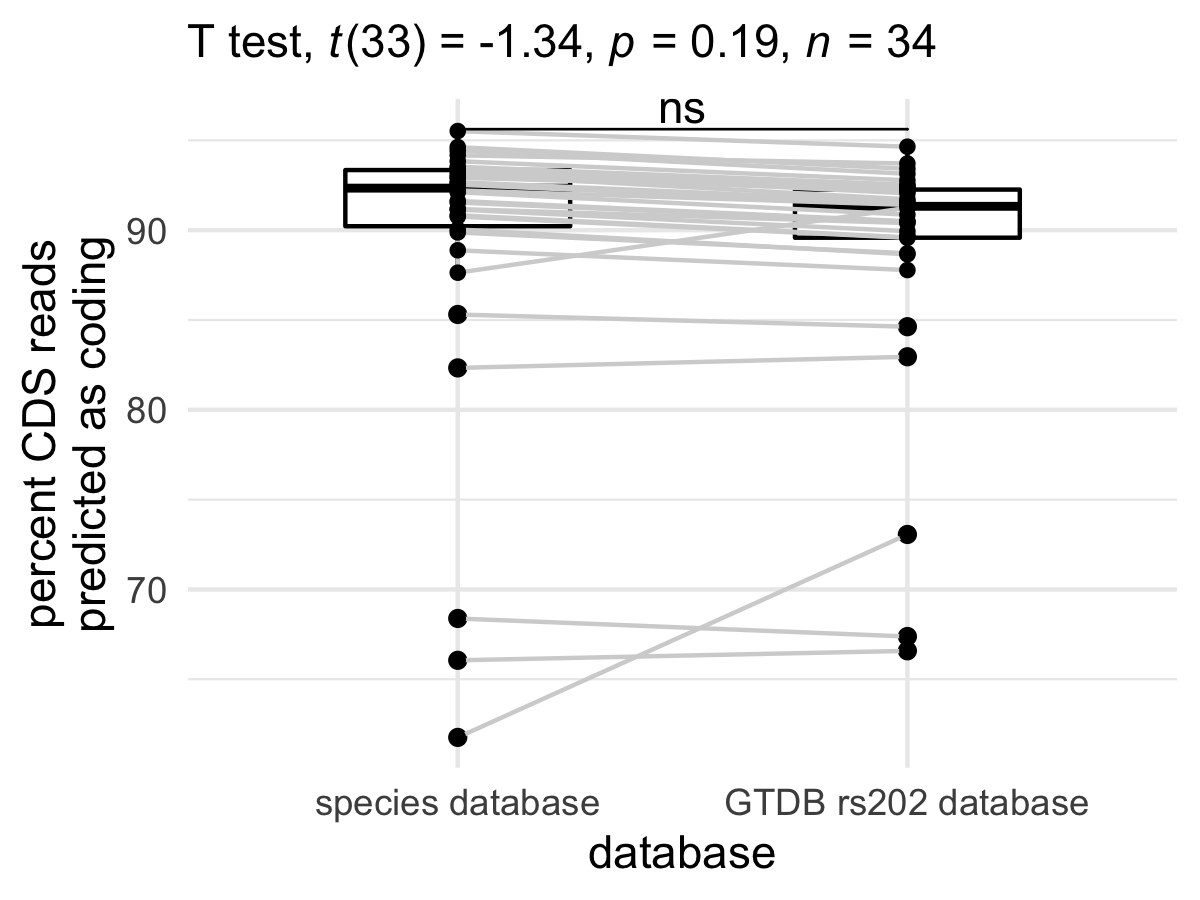

In [67]:
# adjust plot size rendered inline
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)

#pdf("orpheum_supp1.pdf", height = 3, width = 4)
bxp + 
  stat_pvalue_manual(stat_test, tip.length = 0) +
  labs(subtitle = get_test_label(stat_test, detailed= TRUE)) +
  theme_minimal() 
#dev.off()

## Combine plots into single panel

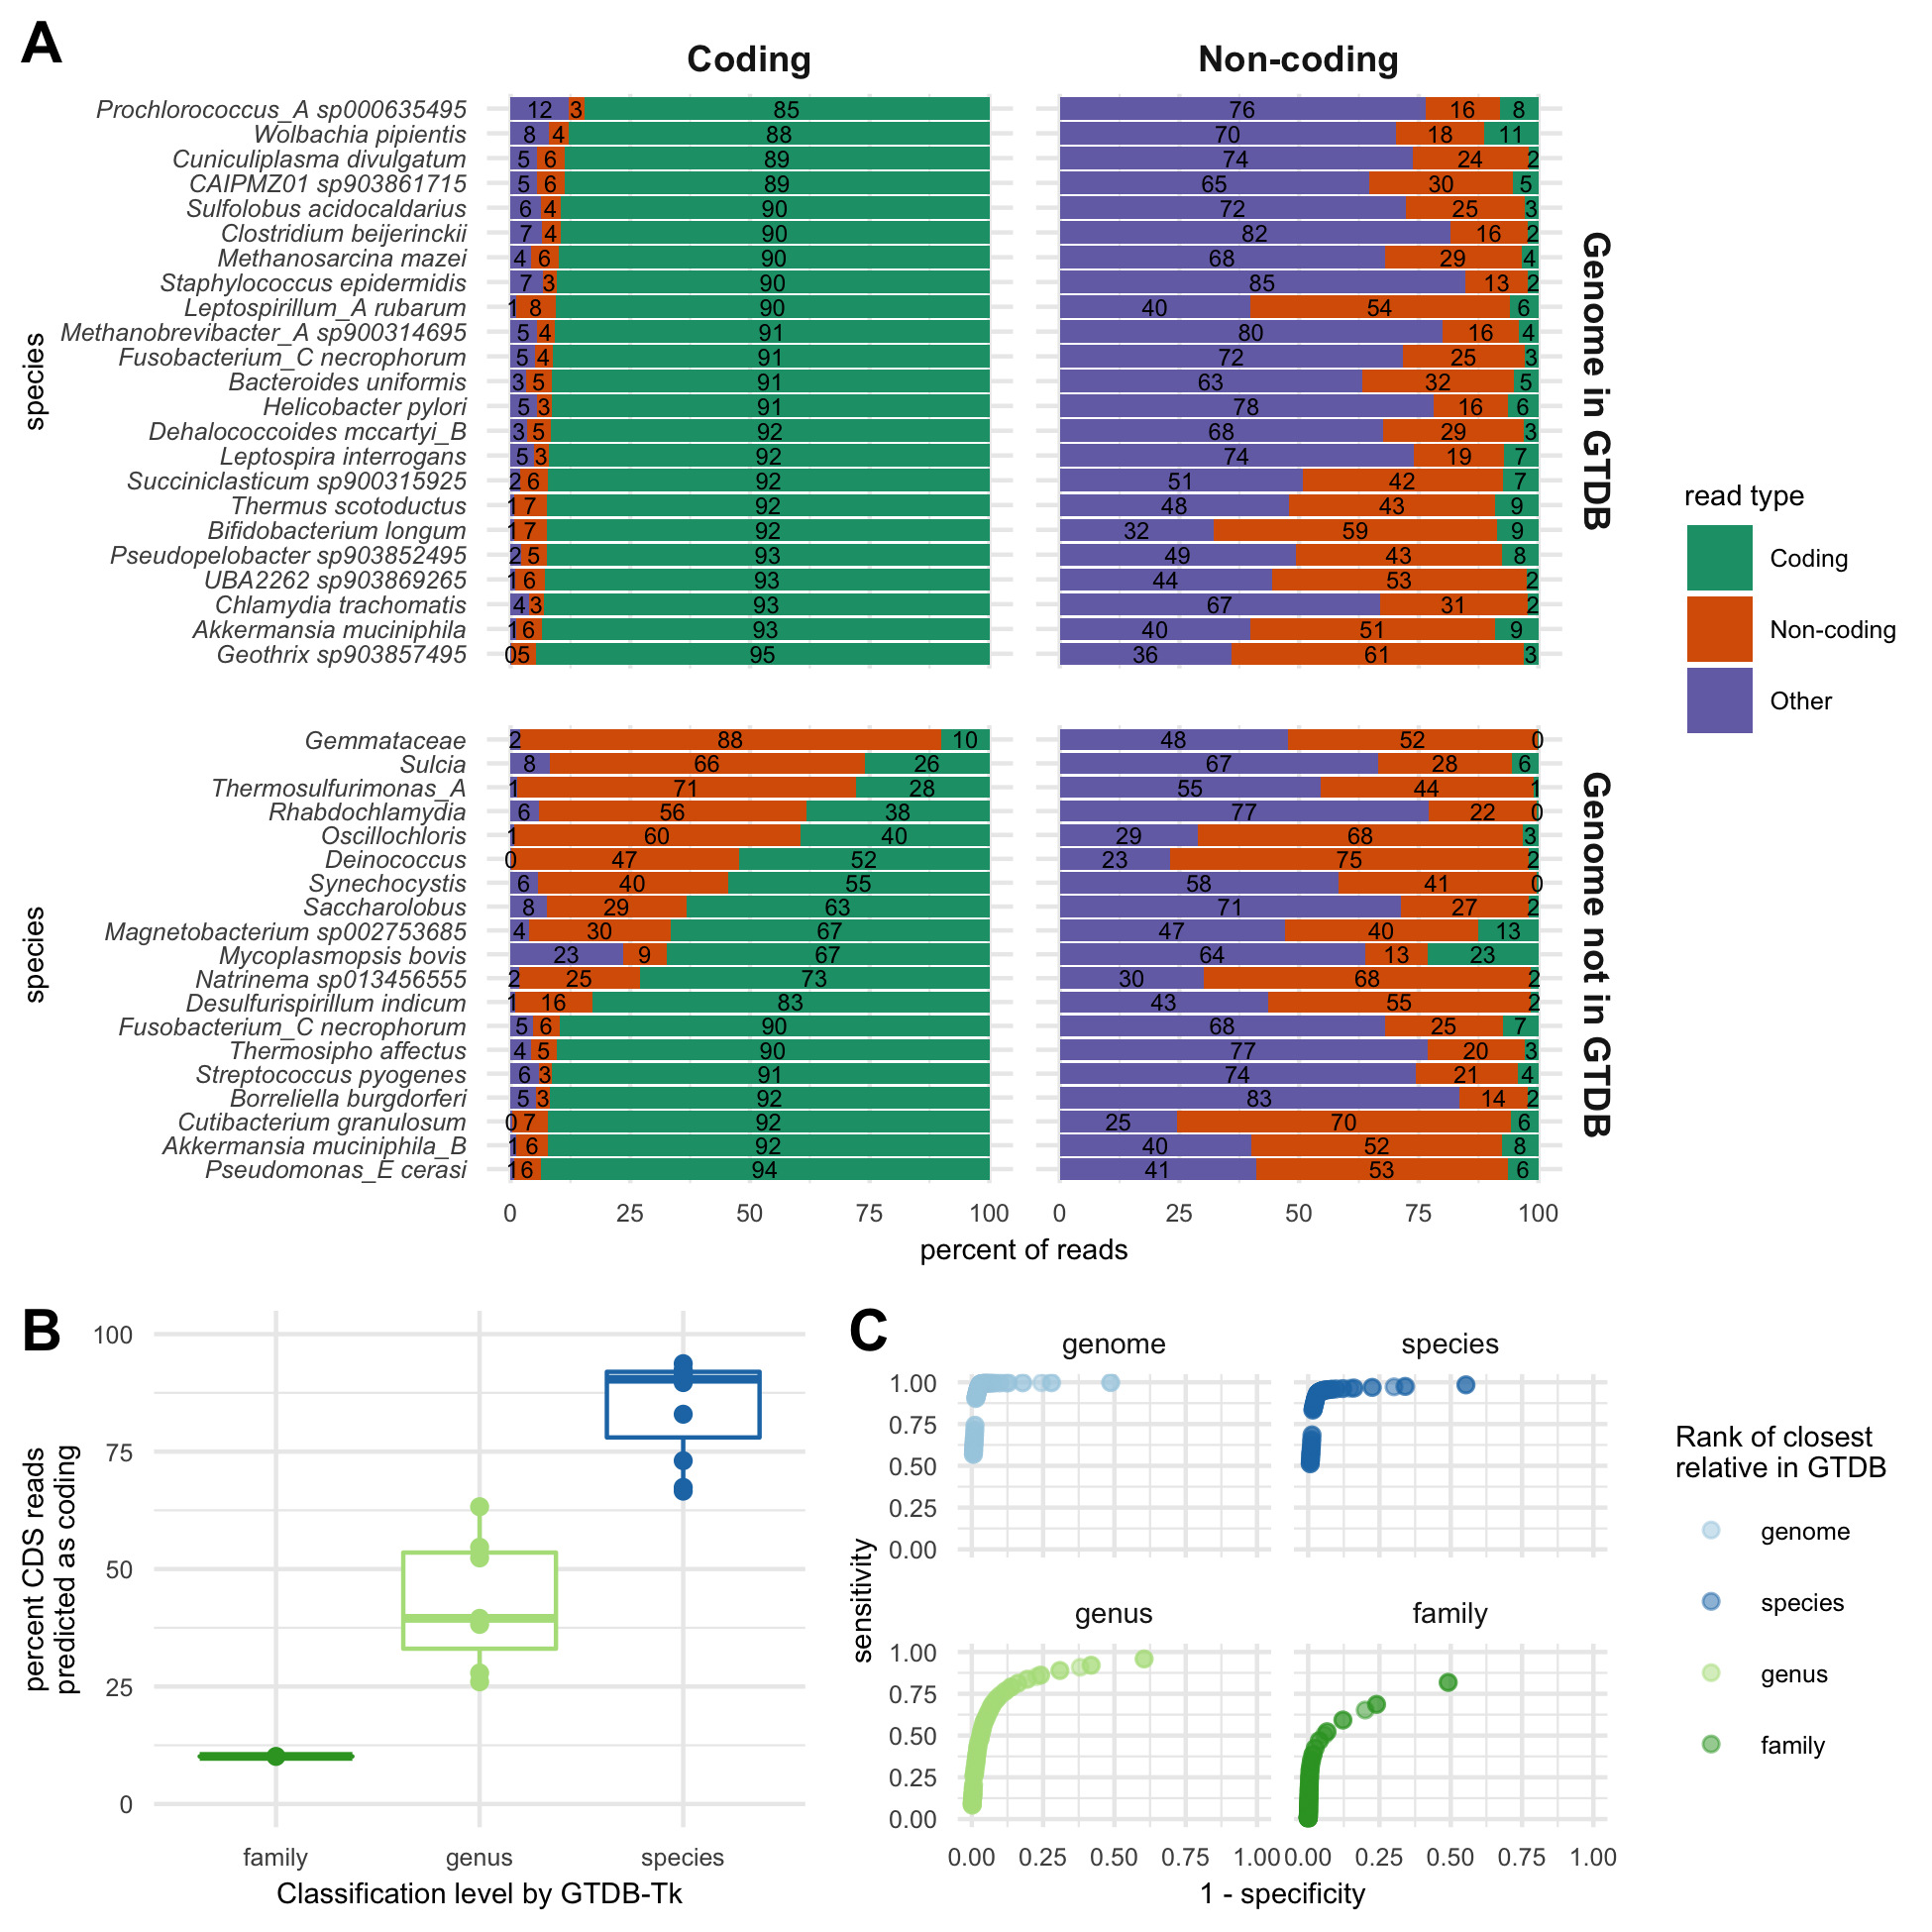

In [94]:
# adjust plot size rendered inline
options(repr.plot.width = 6.5, repr.plot.height = 6.5, repr.plot.res = 300)


#pdf("orpheum_fig.pdf", height = 6.5, width = 6.5)
ggarrange(cds_noncds_gtdb_nongtdb_plt, 
          ggarrange(refseq_gtdbtk_plt, jaccard_tp_plt, 
                    labels = c("B", "C"), ncol = 2, widths = c(3, 4)),
          nrow = 2, labels = c("A", ""), heights = c(2, 1))
#dev.off()

## Pseudogene results

In [95]:
pseudo <- Sys.glob("outputs/noncds_pseudogenes/gtdb-rs202/protein-k10/*summary.tsv") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  mutate(pct = (noncds_predicted_as_coding_in_pseudogenes/noncds_predicted_as_coding)*100) 

In [96]:
pseudo <- pseudo %>%
  summarise(mean_pct = mean(pct), 
            sd_pct = sd(pct),
            mean_reads = mean(noncds_predicted_as_coding_in_pseudogenes), 
            sd_reads = sd(noncds_predicted_as_coding_in_pseudogenes))

In [97]:
pseudo

mean_pct,sd_pct,mean_reads,sd_reads
<dbl>,<dbl>,<dbl>,<dbl>
12.38034,13.84065,746.913,768.2229


## Sourmash compare & mantel test

In [98]:
comp_orph <- read_csv("outputs/orpheum_compare/gtdb-rs202/protein-k10/comp.csv", show_col_types = F)
comp_bakta <- read_csv("outputs/bakta_assemblies_compare/comp.csv", show_col_types = F)

In [99]:
mean(as.matrix(comp_bakta), na.rm =T)

[1] 0.02561618

In [100]:
mean(as.matrix(comp_orph), na.rm =T)

[1] 0.02461858

In [101]:
tmp <- mantel(comp_orph, comp_bakta)

In [102]:
tmp


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = comp_orph, ydis = comp_bakta) 

Mantel statistic r: 0.9975 
      Significance: 0.001 

Upper quantiles of permutations (null model):
      90%       95%     97.5%       99% 
-0.000195  0.001072  0.002815  0.006148 
Permutation: free
Number of permutations: 999


In [103]:
differences <- comp_bakta - comp_orph
mean(as.matrix(differences), na.rm = T) * 100

[1] 0.09976024

## Stat coding as noncoding

In [104]:
cds_as_coding <-  Sys.glob("outputs/cds_as_coding_bwa/gtdb-rs202/protein-k10/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "accession") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(accession = gsub("outputs/cds_as_coding_bwa/gtdb-rs202/protein-k10/", "", accession)) %>%
  mutate(accession = gsub(".[12]_.*", "", accession)) %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat == "error rate") %>%
  select(accession, stat, coding_value = value)

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [105]:
cds_as_noncoding <- Sys.glob("outputs/cds_as_noncoding_bwa/gtdb-rs202/protein-k10/*stat") %>%
  set_names() %>%
  map_dfr(read_tsv, col_names = c("stat", "value", "comment"), col_types = "cc", .id = "accession") %>%
  mutate(value = as.numeric(gsub("\t.*", "", value))) %>%
  mutate(accession = gsub("outputs/cds_as_noncoding_bwa/gtdb-rs202/protein-k10/", "", accession)) %>%
  mutate(accession = gsub(".[12]_.*", "", accession)) %>%
  mutate(stat = gsub(":", "", stat)) %>%
  filter(stat == "error rate") %>%
  select(accession, stat, noncoding_value = value)

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

In [106]:
error_rate <- left_join(cds_as_coding, cds_as_noncoding)
t.test(error_rate$coding_value, error_rate$noncoding_value)

Joining, by = c("accession", "stat")



	Welch Two Sample t-test

data:  error_rate$coding_value and error_rate$noncoding_value
t = -12.226, df = 41.92, p-value = 2.069e-15
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.006095508 -0.004368212
sample estimates:
  mean of x   mean of y 
0.004457326 0.009689186 
